In [43]:
import numpy as np
import pandas as pd
import os
import h5py
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# To get the images and labels from file
with h5py.File('data/Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# To convert the labels to categorical 10 classes
#cat_labels = utils.to_categorical(labels, 10)

# To convert to desirable type
#labels = labels.astype(np.float32)
images = images.astype(np.uint8)

In [3]:
labels

array([0, 0, 0, ..., 9, 9, 9], dtype=uint8)

In [4]:
images.shape

(17736, 256, 256, 3)

In [5]:
label_names = ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Shaped Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']

In [6]:
class_dict = {num:gal_type for num,gal_type in zip(range(10), label_names)}
class_dict

{0: 'Disturbed',
 1: 'Merging',
 2: 'Round Smooth',
 3: 'In-between Round Smooth',
 4: 'Cigar Shaped Smooth',
 5: 'Barred Spiral',
 6: 'Unbarred Tight Spiral',
 7: 'Unbarred Loose Spiral',
 8: 'Edge-on without Bulge',
 9: 'Edge-on with Bulge'}

In [7]:
num_plots = 10

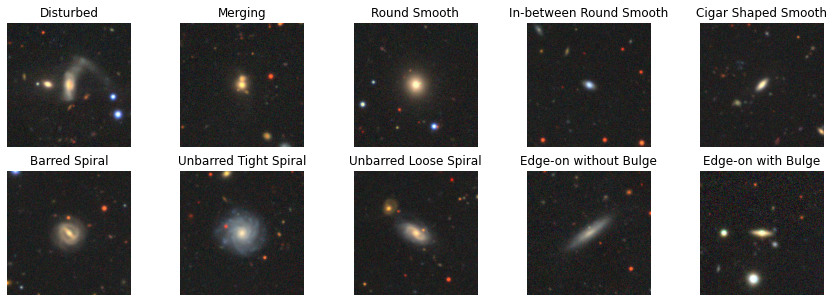

In [8]:
fig, axs = plt.subplots(2,5, figsize=(15,5), sharex=True, sharey=True)

for idx, plot in enumerate(axs.flatten()):
    class_idx = np.argwhere(labels==idx)[0][0]
    plot.imshow(images[class_idx])
    plot.set_title(class_dict[labels[class_idx]])
    plot.axis('off')

#plt.savefig('galaxy-classification/imgs/class_examples.png')

In [9]:
labs, counts = np.unique(labels, return_counts=True)

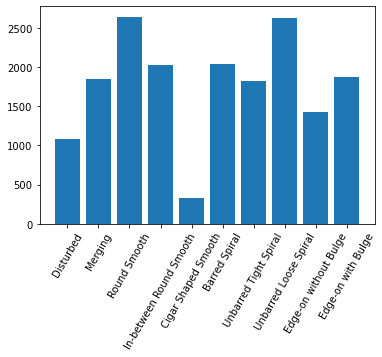

In [10]:
fig, ax = plt.subplots()
ax.bar(labs, counts, tick_label = label_names)
ax.set_xticklabels(label_names, rotation=60);

In [11]:
# Split into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(images, cat_labels, test_size=0.1, stratify=labels)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, stratify=labels)

In [13]:
def count_class(y, ax, xtick_labels = label_names):
    labels, count = np.unique(y, return_counts = True)
    ax.bar(labels, count, tick_label = xtick_labels)
    ax.set_xticklabels(xtick_labels, rotation=60);

Text(0.5, 1.0, 'Test Set')

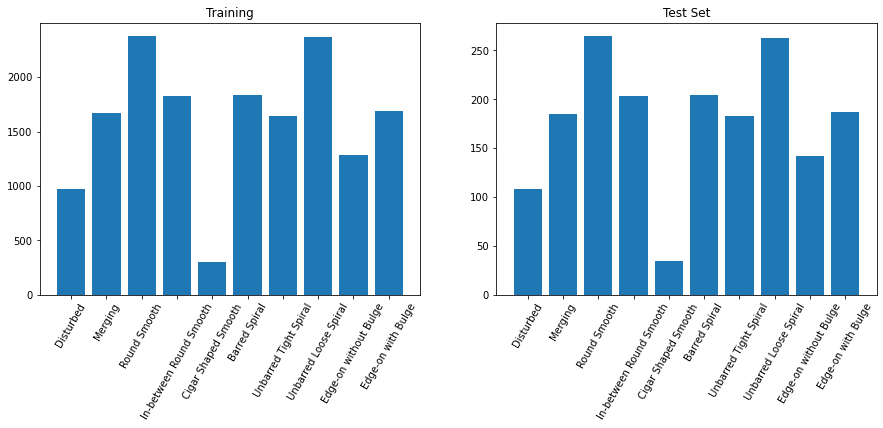

In [14]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
for ax,y in zip(axs.flatten(),[y_train, y_test]):
    count_class(y, ax)
axs[0].set_title('Training')
axs[1].set_title('Test Set')

## Convolutional Neural Network

In [15]:
# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

In [16]:
resized_images = tf.image.resize(X_train,[128,128])

In [164]:
train_images, test_images = resized_images.numpy()[:,32:96,32:96,:], tf.image.resize(X_test,[128,128]).numpy()[:,32:96,32:96,:]

In [166]:
conv_kernel_sz = (5,5)
in_shape = (64,64,3)

In [193]:
def create_model(kernel_size = (5,5), input_shape = (64,64,3), drop_out = 0):
    # Layer 1
    model = keras.models.Sequential([
        keras.layers.Conv2D(8, kernel_size, activation='relu',
                            input_shape=in_shape, padding = "same"),
        keras.layers.MaxPooling2D((2, 2))
    ])
    #
    #model.add(keras.layers.Conv2D(8, kernel_size, activation = 'relu', padding = 'same'))
    #model.add(keras.layers.MaxPool2D(2,2))
    
    #
    model.add(keras.layers.Conv2D(16, kernel_size, activation = 'relu', padding = 'same'))
    model.add(keras.layers.MaxPool2D(2,2))
    #model.add(keras.layers.Dropout(drop_out))
    # Layer 2
    model.add(keras.layers.Conv2D(16, kernel_size, activation = 'relu', padding = 'same'))
    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Dropout(drop_out))
    model.add(keras.layers.Flatten())
    # Layer 3
    model.add(keras.layers.Dense(64, activation = 'relu'))
    #model.add(keras.layers.Dropout(drop_out))
    # Layer 4
    model.add(keras.layers.Dense(10,  activation = "softmax"))
    
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

#model = KerasClassifier(build_fn=create_model, epochs=10, kernel_size = (3,3))
model = create_model((3,3), in_shape, 0.05)

In [227]:
conv_kernel = (3,3)
in_size = (64,64,3)
drop_out = 0.2

def create_CNN4(kernel_size=(3,3), input_shape=(64,64,3), drop_out=0.2, l2_reg=0):
    # Layer 1
    CNN3 = keras.models.Sequential([
    keras.layers.Conv2D(16, kernel_size, activation='relu',
                        input_shape=in_shape, padding = "same"),
    keras.layers.MaxPooling2D((2, 2))
    ])

    # Layer 2
    CNN3.add(keras.layers.Conv2D(16, kernel_size, activation = 'relu', padding = 'same'))
    CNN3.add(keras.layers.MaxPool2D(2,2))
    #model.add(keras.layers.Dropout(drop_out))
    # Layer 3
    CNN3.add(keras.layers.Conv2D(32, kernel_size, activation = 'relu', padding = 'same', kernel_regularizer = keras.regularizers.l2(l2_reg)))
    CNN3.add(keras.layers.MaxPool2D(2,2))

    CNN3.add(keras.layers.Conv2D(32, kernel_size, activation = 'relu', padding = 'same', kernel_regularizer = keras.regularizers.l2(l2_reg)))
    CNN3.add(keras.layers.MaxPool2D(2,2))
    CNN3.add(keras.layers.Dropout(drop_out))
    CNN3.add(keras.layers.Flatten())
    # Layer 4
    CNN3.add(keras.layers.Dense(128, activation = 'relu', kernel_regularizer = keras.regularizers.l2(l2_reg)))
    #model.add(keras.layers.Dropout(drop_out))
    # Layer 5
    CNN3.add(keras.layers.Dense(10,  activation = "softmax"))

    CNN3.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

    return CNN3

CNN4 = KerasClassifier(build_fn=create_CNN4, epochs=20, kernel_size = (3,3))

In [184]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 8, 8, 16)        

In [228]:
param_grid = dict(drop_out=[0.05, 0.2, 0.3], epochs=[20], l2_reg = [0.001, 0.01, 0.1])
grid = GridSearchCV(estimator=CNN4, param_grid=param_grid, n_jobs=-1, verbose=4, return_train_score=True, cv=3)
grid_result = grid.fit(train_images, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Epoch 1/20
499/499 [==============================] - 29s 55ms/step - loss: 1.9109 - accuracy: 0.3250
Epoch 2/20
499/499 [==============================] - 23s 45ms/step - loss: 1.4907 - accuracy: 0.4926
Epoch 3/20
499/499 [==============================] - 23s 46ms/step - loss: 1.3321 - accuracy: 0.5675
Epoch 4/20
499/499 [==============================] - 24s 48ms/step - loss: 1.2348 - accuracy: 0.6084
Epoch 5/20
499/499 [==============================] - 25s 49ms/step - loss: 1.1621 - accuracy: 0.6355
Epoch 6/20
499/499 [==============================] - 24s 48ms/step - loss: 1.1082 - accuracy: 0.6613
Epoch 7/20
499/499 [==============================] - 25s 50ms/step - loss: 1.0711 - accuracy: 0.6734
Epoch 8/20
499/499 [==============================] - 25s 49ms/step - loss: 1.0360 - accuracy: 0.6854
Epoch 9/20
499/499 [==============================] - 25s 49ms/step - loss: 1.0145 - accuracy: 0.6896
Epoch 10/20
499/499 [=

In [230]:
grid_result.best_params_

{'drop_out': 0.2, 'epochs': 20, 'l2_reg': 0.001}

In [231]:
grid_result.best_score_

0.7205235362052917

In [207]:
history = model.fit(train_images, y_train, epochs=20, verbose=1, validation_data=(test_images, y_test))

Epoch 1/20
499/499 [==============================] - 15s 30ms/step - loss: 0.8208 - accuracy: 0.7197 - val_loss: 1.1498 - val_accuracy: 0.6240
Epoch 2/20
499/499 [==============================] - 14s 27ms/step - loss: 0.8109 - accuracy: 0.7248 - val_loss: 1.1557 - val_accuracy: 0.6291
Epoch 3/20
499/499 [==============================] - 14s 27ms/step - loss: 0.8014 - accuracy: 0.7252 - val_loss: 1.1858 - val_accuracy: 0.6167
Epoch 4/20
 41/499 [=>............................] - ETA: 13s - loss: 0.7423 - accuracy: 0.7485

KeyboardInterrupt: 

In [225]:
CNN4_history = CNN3.fit(train_images, y_train, epochs=20, verbose=1, validation_data=(test_images, y_test))

Epoch 1/20
499/499 [==============================] - 27s 52ms/step - loss: 1.8450 - accuracy: 0.3624 - val_loss: 1.5897 - val_accuracy: 0.4363
Epoch 2/20
499/499 [==============================] - 24s 48ms/step - loss: 1.4403 - accuracy: 0.5203 - val_loss: 1.3412 - val_accuracy: 0.5800
Epoch 3/20
499/499 [==============================] - 24s 49ms/step - loss: 1.2783 - accuracy: 0.5915 - val_loss: 1.2408 - val_accuracy: 0.6206
Epoch 4/20
499/499 [==============================] - 25s 49ms/step - loss: 1.1868 - accuracy: 0.6338 - val_loss: 1.1612 - val_accuracy: 0.6488
Epoch 5/20
499/499 [==============================] - 25s 49ms/step - loss: 1.1430 - accuracy: 0.6420 - val_loss: 1.1272 - val_accuracy: 0.6725
Epoch 6/20
499/499 [==============================] - 25s 49ms/step - loss: 1.0818 - accuracy: 0.6685 - val_loss: 1.1036 - val_accuracy: 0.6607
Epoch 7/20
499/499 [==============================] - 25s 49ms/step - loss: 1.0468 - accuracy: 0.6805 - val_loss: 1.0608 - val_accuracy:

In [170]:
model.evaluate(test_images, y_test)

56/56 [==============================] - 0s 6ms/step - loss: 0.9205 - accuracy: 0.7182


[0.9205369353294373, 0.7181510925292969]

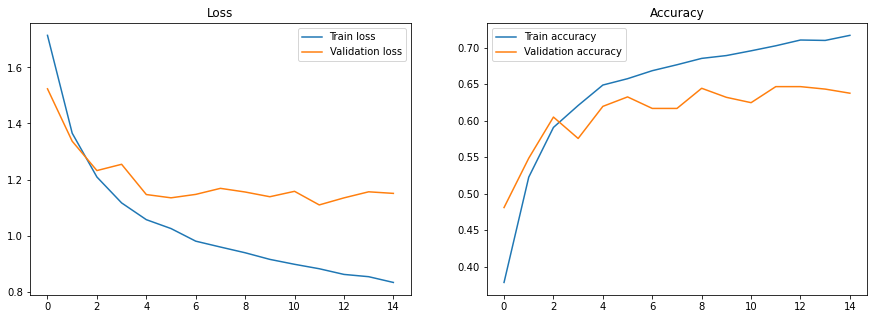

In [221]:
def show_final_history(history):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history['loss'], label='Train loss')
    ax[0].plot(history.epoch, history.history['val_loss'], label='Validation loss')
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history['accuracy'], label='Train accuracy')
    ax[1].plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
    ax[0].legend()
    ax[1].legend()

show_final_history(history)
#plt.savefig('imgs/train_val_plots_64in_CNN4_20epochs.png')

In [232]:
ypred = grid_result.best_estimator_.predict(test_images)

/Users/jordyns/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [233]:
accuracy_score(y_test, ypred)

0.7361894024802705

In [102]:
y_pred = model.predict_classes(test_images)

/Users/jordyns/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


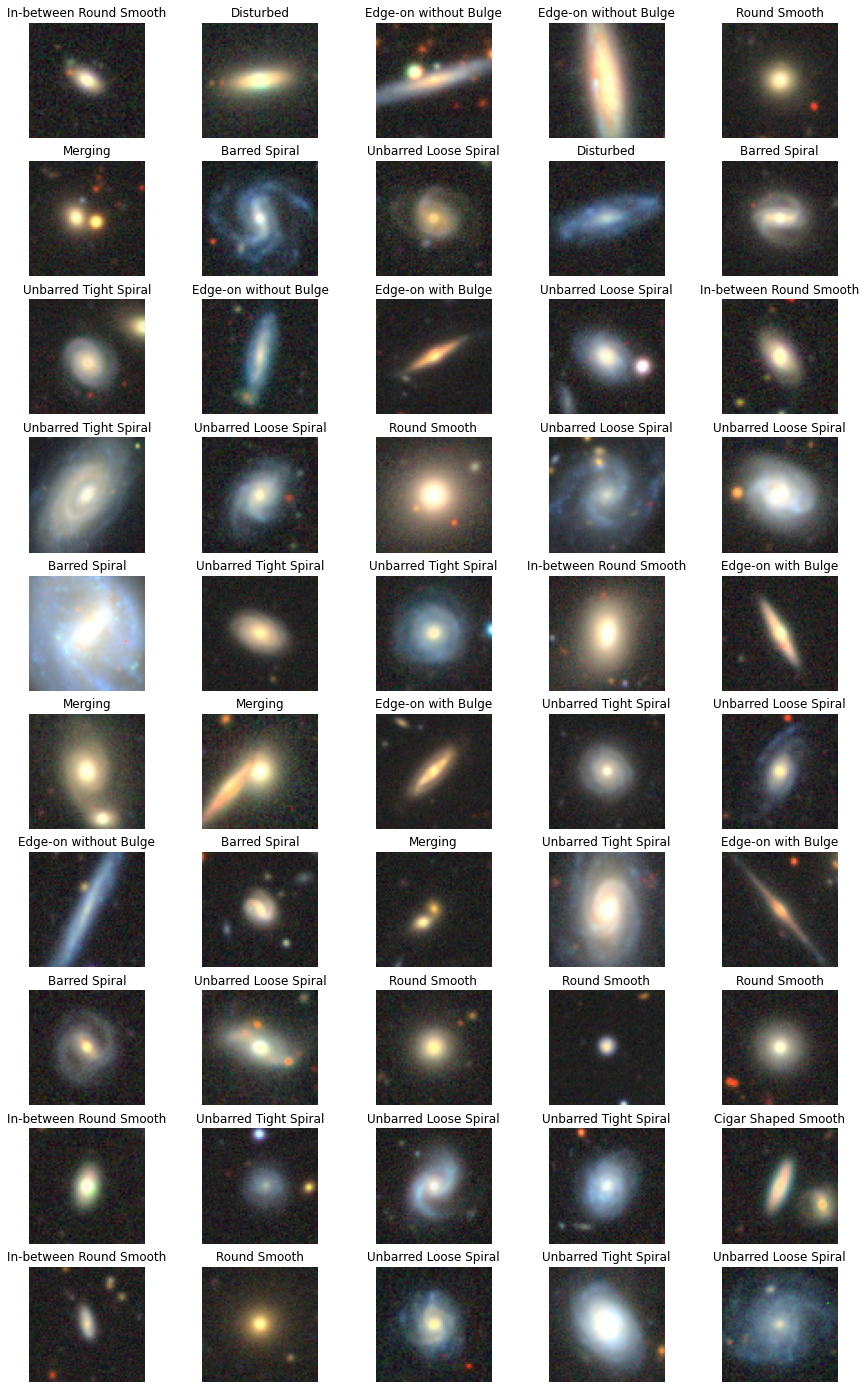

In [210]:
fig, axs = plt.subplots(10,5, figsize=(15,25), sharex=True, sharey=True)

for idx, plot in enumerate(axs.flatten()):
    #class_idx = np.argwhere(labels==idx)[0][0]
    plot.imshow(test_images[idx])
    plot.set_title(class_dict[y_test[idx]])
    plot.axis('off')

In [234]:
cm = confusion_matrix(y_test, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

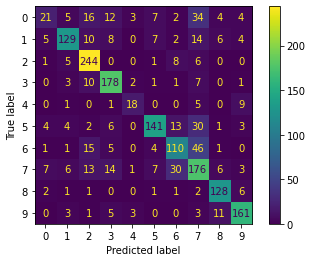

In [235]:
disp.plot()

In [222]:
# Save the model
from datetime import datetime
saved_model_path = "./saved_models/CNN4_20epochs_64in{}.h5".format(datetime.now().strftime("%Y%m%d"))
model.save(saved_model_path)

In [98]:
loaded_model = keras.models.load_model(saved_model_path)

In [99]:
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 16)        1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [100]:
loaded_model.evaluate(test_images, y_test)

56/56 [==============================] - 1s 12ms/step - loss: 2.0487 - accuracy: 0.6505


[2.048696994781494, 0.6505073308944702]

In [103]:
y_compare = loaded_model.predict_classes(test_images)

/Users/jordyns/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


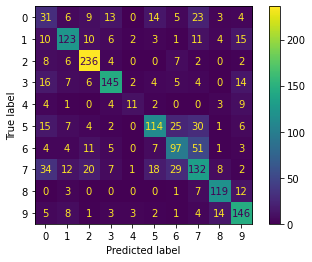

In [104]:
cm_2 = confusion_matrix(y_test, y_compare)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)
disp_2.plot()

## Examine misclassifications

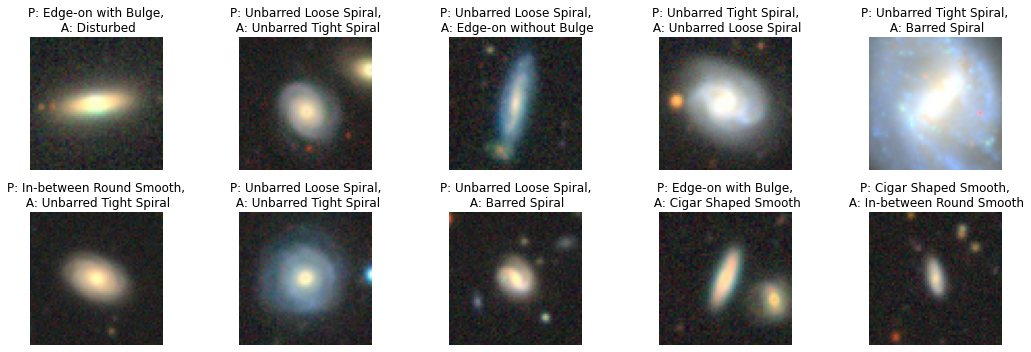

In [262]:
miss_mask = ~(ypred == y_test)
misses, missed_pred, missed_actual = test_images[miss_mask], ypred[miss_mask], y_test[miss_mask]


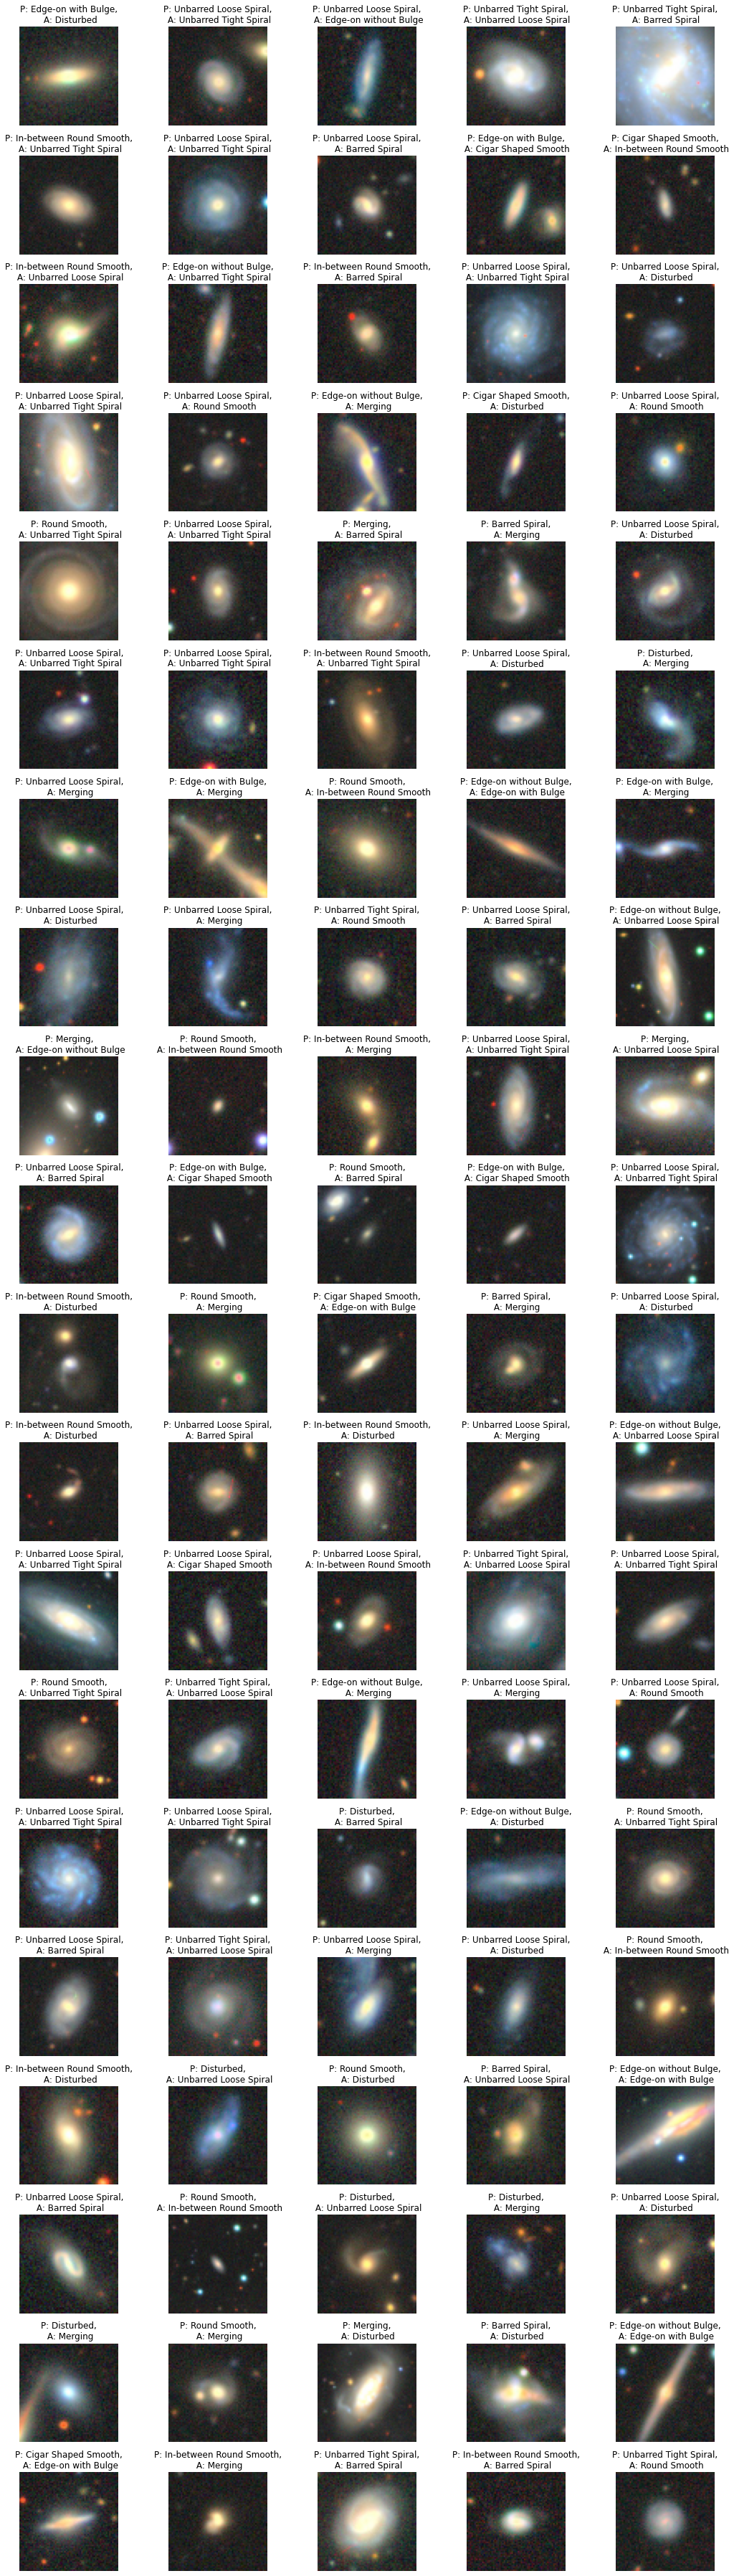

In [269]:
num=100
fig, axs = plt.subplots(int(num/5),5,figsize = (15,int((5*num)/10)))
for miss,ax,miss_pred, miss_actual in zip(misses[:num], axs.flatten(), missed_pred[:num], missed_actual[:num]):
    ax.imshow(miss)
    ax.set_title(f'P: {class_dict[miss_pred]},\n A: {class_dict[miss_actual]}')
    ax.axis('off')
plt.tight_layout()

In [248]:
test_images[~(ypred == y_test)][:2]

array([[[[0.11274511, 0.14509805, 0.10980393],
         [0.1009804 , 0.13333334, 0.1137255 ],
         [0.13137256, 0.13529412, 0.17156863],
         ...,
         [0.13431373, 0.2254902 , 0.23137255],
         [0.10294118, 0.17254902, 0.14313726],
         [0.14411765, 0.11960785, 0.12843138]],

        [[0.15294118, 0.12254903, 0.15      ],
         [0.01372549, 0.19803922, 0.20294118],
         [0.06470589, 0.19117647, 0.19117647],
         ...,
         [0.15686275, 0.18235295, 0.14607844],
         [0.03529412, 0.18137255, 0.11666667],
         [0.19019608, 0.14411765, 0.18137255]],

        [[0.14901961, 0.12058824, 0.16470589],
         [0.14411765, 0.20294118, 0.23235296],
         [0.06862745, 0.24313727, 0.20686275],
         ...,
         [0.10490197, 0.18431374, 0.1382353 ],
         [0.15588236, 0.17745098, 0.14901961],
         [0.19411765, 0.11176471, 0.17745098]],

        ...,

        [[0.08333334, 0.17843138, 0.14803922],
         [0.16764706, 0.12843138, 0.1235294 ]